In [ ]:
from recommender_clustering import run_experiment
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os

def compute_metrics_all(
    dataset_names=['ml-small', 'ml-1m', 'books', 'jester'],
    method='hard',
    n_clusters_range=range(2, 101, 5),
    top_k_val=10,
    output_file='results.csv'
):
    """
    Ejecuta run_experiment para cada dataset en dataset_names
    y para cada valor de n_clusters en n_clusters_range.
    Guarda resultados en un CSV y permite resume si se interrumpe.
    """
    # Si existe archivo de resultados, cargar para saber qué ya se computó
    if os.path.exists(output_file):
        df_existing = pd.read_csv(output_file)
    else:
        # Crear DataFrame vacío con las columnas deseadas
        df_existing = pd.DataFrame(columns=[
            'dataset', 'method', 'n_clusters', 'top_k',
            'nmae', 'nrmse', 'entropy'
        ])

    # Iterar, saltar combinaciones ya en el archivo
    for ds in dataset_names:
        for n in tqdm(n_clusters_range, desc=f'Procesando {ds} ({method})'):
            # Verificar si ya existe esta configuración
            if not df_existing[
                (df_existing.dataset == ds) &
                (df_existing.method == method) &
                (df_existing.n_clusters == n) &
                (df_existing.top_k == top_k_val)
            ].empty:
                continue

            # Ejecutar experimento
            nmae, nrmse, entropy = run_experiment(
                dataset_name=ds,
                method=method,
                n_clusters_val=n,
                top_k_val=top_k_val
            )

            # Construir fila y escribir en CSV (modo append)
            row = {
                'dataset': ds,
                'method': method,
                'n_clusters': n,
                'top_k': top_k_val,
                'nmae': nmae,
                'nrmse': nrmse,
                'entropy': entropy
            }
            df_row = pd.DataFrame([row])
            df_row.to_csv(
                output_file,
                mode='a',
                header=not os.path.exists(output_file),
                index=False
            )

            # Agregar a df_existing para evitar recálculos en la misma ejecución
            df_existing = pd.concat([df_existing, df_row], ignore_index=True)

    print(f"Resultados guardados en {output_file}.")

def plot_metrics(
    datasets,
    metrics,
    methods,
    results_file='results.csv',
    save=False,
    save_dir='../Memoria/Figuras'
):
    """
    Genera una comparativa de una o varias métricas frente al número de clústers.

    Parámetros:
    - datasets: lista de nombres de datasets a incluir en la gráfica.
    - metrics: string o lista de strings con nombres de columnas de métricas ('nmae', 'nrmse', 'entropy').
    - methods: string o lista de strings con los métodos ('hard', 'soft', etc.).
    - results_file: ruta al CSV con los resultados.
    - save: booleano, si True guarda la figura en formato PNG.
    - save_dir: directorio donde guardar la figura.
    """

    # Colores fijos por dataset
    dataset_colors = {
        'ml-small': '#1f77b4',
        'ml-1m': '#ff7f0e',
        'books': '#2ca02c',
        'jester': '#d62728',
        'syn': '#9467bd',
        'syn03': '#8c564b',
        'syn80': '#e377c2'
    }

    # Asegurar listas
    if isinstance(metrics, str):
        metrics = [metrics]
    if isinstance(methods, str):
        methods = [methods]

    # Cargar datos
    df = pd.read_csv(results_file)

    # Preparar la figura
    plt.figure(figsize=(8, 6))

    # Plot para cada combinación de dataset, método y métrica
    for ds in datasets:
        color = dataset_colors.get(ds, 'black')  # Color por defecto: negro si no está definido
        for method in methods:
            df_sub = df[(df.dataset == ds) & (df.method == method)]
            for metric in metrics:
                plt.plot(
                    df_sub.n_clusters,
                    df_sub[metric],
                    marker='o',
                    label=f"{ds} - {method} - {metric}",
                    color=color
                )

    # Etiquetas y leyenda
    met_str = ",".join(metrics)
    plt.title(f"Comparativa {met_str} vs Número de Clústers")
    plt.xlabel("Número de Clústers")
    plt.ylabel(met_str)
    plt.legend()
    plt.grid(True)

    # Guardar si se solicita
    if save:
        os.makedirs(save_dir, exist_ok=True)
        filename = f"{met_str}-{'-'.join(methods)}-all.png"
        plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        print(f"Figura guardada en {os.path.join(save_dir, filename)}")

    # Mostrar plot
    plt.show()


def plot_metrics_all(results, n_clusters_range):
    """
    Dibuja tres gráficas (NMAE, NRMSE, Entropía) superponiendo
    las curvas de cada dataset contenidas en `results`.
    
    - results: dict devuelto por compute_metrics_all
    - n_clusters_range: iterable con los mismos valores usados al calcular
    """
    # Define estilos y marcadores para cada dataset
    estilos = {
        'ml-small': {'marker':'o', 'linestyle':'-', 'label':'MovieLens Small'},
        'ml-1m':    {'marker':'s', 'linestyle':'--','label':'MovieLens 1M'},
        'books':    {'marker':'^', 'linestyle':'-.','label':'Books'},
        'jester':   {'marker':'d', 'linestyle':':', 'label':'Jester'}
    }

    # 1) NMAE
    plt.figure(figsize=(12,6))
    for ds, mets in results.items():
        plt.plot(
            n_clusters_range,
            mets['nmae'],
            marker=estilos[ds]['marker'],
            linestyle=estilos[ds]['linestyle'],
            label=estilos[ds]['label']
        )
    plt.xlabel('Número de Clusters')
    plt.ylabel('NMAE')
    plt.title('Comparativa NMAE vs Número de Clusters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('../Memoria/Figuras/nmae-hard-all.png')
    plt.show()

    # 2) NRMSE
    plt.figure(figsize=(12,6))
    for ds, mets in results.items():
        plt.plot(
            n_clusters_range,
            mets['nrmse'],
            marker=estilos[ds]['marker'],
            linestyle=estilos[ds]['linestyle'],
            label=estilos[ds]['label']
        )
    plt.xlabel('Número de Clusters')
    plt.ylabel('NRMSE')
    plt.title('Comparativa NRMSE vs Número de Clusters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('../Memoria/Figuras/nrmse-hard-all.png')
    plt.show()

    # 3) Entropía
    plt.figure(figsize=(12,6))
    for ds, mets in results.items():
        plt.plot(
            n_clusters_range,
            mets['entropy'],
            marker=estilos[ds]['marker'],
            linestyle=estilos[ds]['linestyle'],
            label=estilos[ds]['label']
        )
    plt.xlabel('Número de Clusters')
    plt.ylabel('Entropía')
    plt.title('Comparativa Entropía vs Número de Clusters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('../Memoria/Figuras/entropy-hard-all.png')
    plt.show()



## Kmeans Euclidean

In [ ]:
n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='hard',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='hard_pearson',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='fuzzy',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='fuzzy_pearson',
    n_clusters_range=n_clusters,
    top_k_val=10
)

Procesando ml-small (hard): 100%|██████████| 20/20 [00:00<00:00, 653.74it/s]


Procesando syn80 (hard): 100%|██████████| 20/20 [00:00<00:00, 1576.42it/s]


Resultados guardados en results.csv.


Procesando syn80 (hard_pearson): 100%|██████████| 20/20 [00:00<00:00, 1610.07it/s]


Resultados guardados en results.csv.


Procesando ml-1m (fuzzy):   5%|▌         | 1/20 [01:10<22:10, 70.04s/it]

Figura guardada en ../Memoria/Figuras/nmae-hard-sin.png


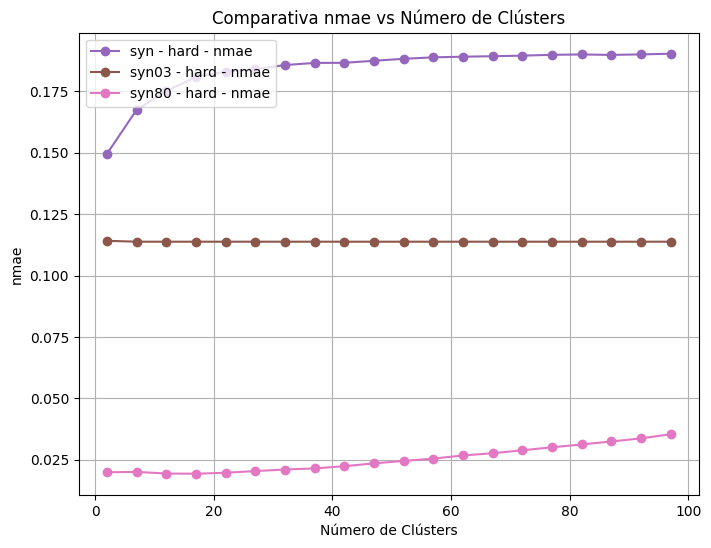

Figura guardada en ../Memoria/Figuras/nrmse-hard-sin.png


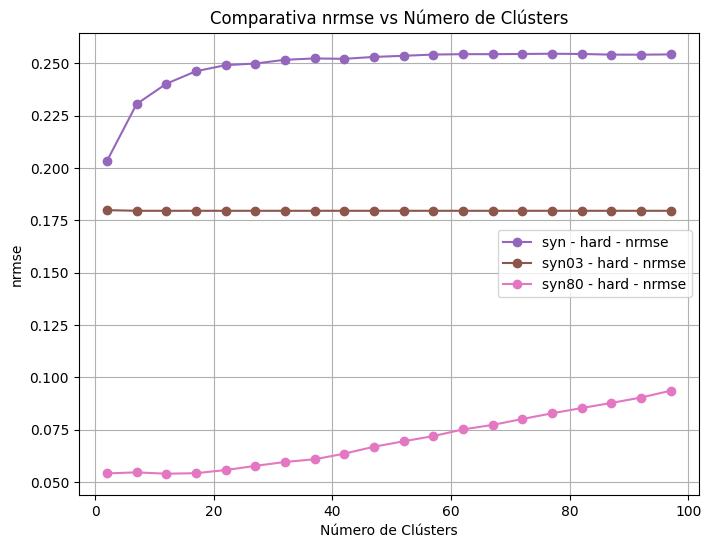

Figura guardada en ../Memoria/Figuras/entropy-hard-sin.png


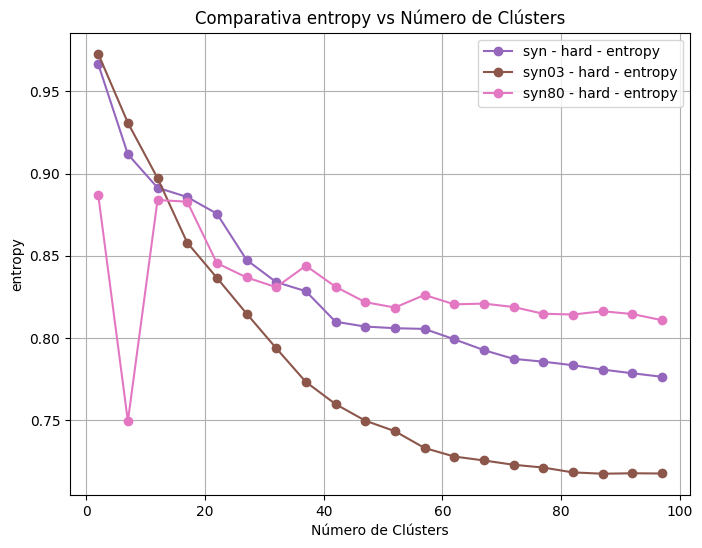

In [ ]:
plot_metrics(
    datasets=['syn', 'syn03', 'syn80'],
    metrics=['nmae'],
    methods=['hard'],
    results_file='results.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)

plot_metrics(
    datasets=['syn', 'syn03', 'syn80'],
    metrics=['nrmse'],
    methods=['hard'],
    results_file='results.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)

plot_metrics(
    datasets=['syn', 'syn03', 'syn80'],
    metrics=['entropy'],
    methods=['hard'],
    results_file='results.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)

Figura guardada en ../Memoria/Figuras/nmae-hard_pearson-sin.png


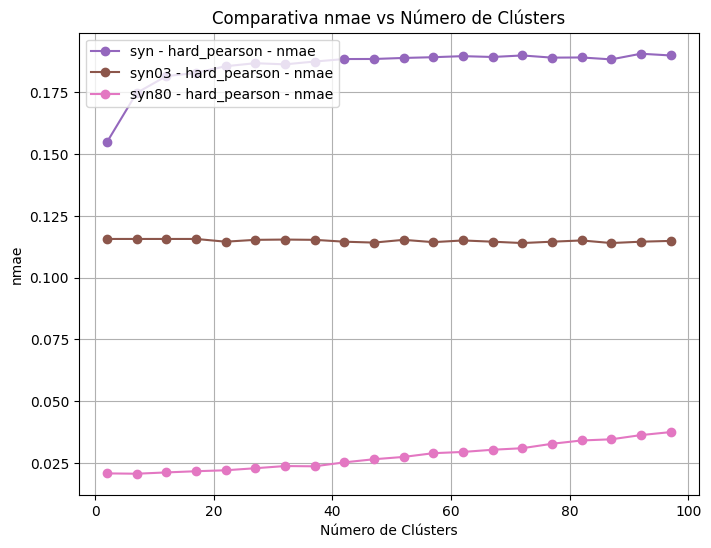

Figura guardada en ../Memoria/Figuras/nrmse-hard_pearson-sin.png


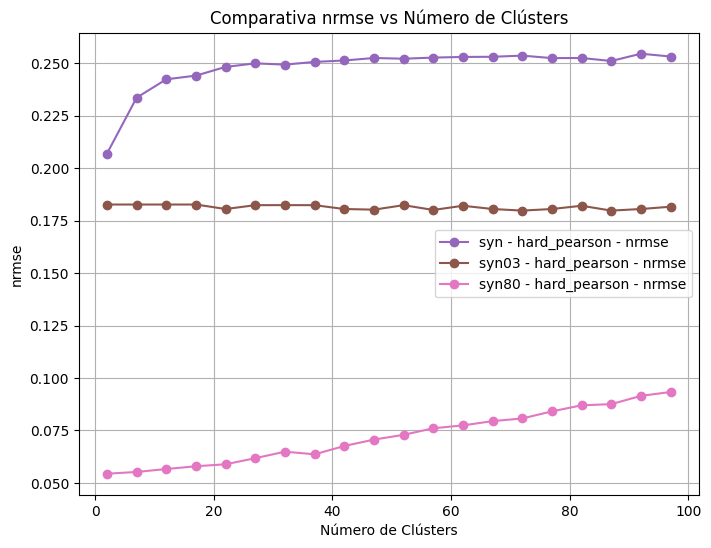

Figura guardada en ../Memoria/Figuras/entropy-hard_pearson-sin.png


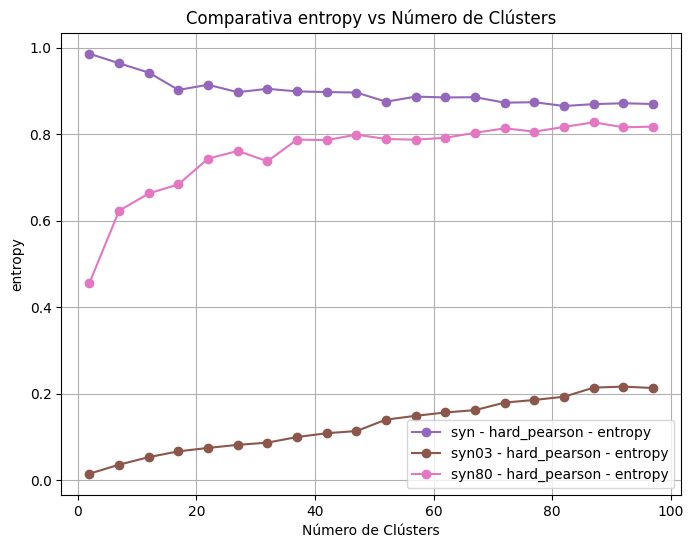

In [ ]:
plot_metrics(
    datasets=['syn', 'syn03', 'syn80'],
    metrics=['nmae'],
    methods=['hard_pearson'],
    results_file='results.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)

plot_metrics(
    datasets=['syn', 'syn03', 'syn80'],
    metrics=['nrmse'],
    methods=['hard_pearson'],
    results_file='results.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)

plot_metrics(
    datasets=['syn', 'syn03', 'syn80'],
    metrics=['entropy'],
    methods=['hard_pearson'],
    results_file='results.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)